In [1]:
import os
import tifffile as tiff
import numpy as np
import torch
from scipy.linalg import svd
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def forward_Casorati(directory):
    out_matrix = None
    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".tif"):
            curr_img = tiff.imread(os.path.join(directory, filename))
            flat_img = np.expand_dims(curr_img.flatten(), axis=1)
            if out_matrix is None:
                out_matrix = flat_img
            else:
                out_matrix = np.concatenate((out_matrix, flat_img), axis=1)
    return curr_img.shape, out_matrix

def backward_Casorati(matrix, shape):
    output = np.zeros((matrix.shape[-1], shape[0], shape[1]))
    for ch in range(matrix.shape[-1]):
        curr = matrix.transpose()[ch]
        output[ch, ...] = curr.reshape(shape[0], shape[1])
    return output

def L1_norm(matrix):
    return np.sum(np.abs(matrix))

def Frobenius_norm(matrix):
    return np.sum(np.square(matrix))

def Nuc_norm(matrix):
    _, S, _ = svd(matrix)
    return np.sum(S)

def soft_thresholding(X, tau):
    return torch.sign(X) * torch.maximum(torch.abs(X - tau), torch.tensor(0.0, device=device))

def singular_value_thresholding(X, tau):
    U, Sigma, V = torch.svd(X)
    Sigma_thresh = soft_thresholding(Sigma, tau)
    return U @ torch.diag(Sigma_thresh) @ V.T

cuda


In [2]:
# Import data
root = "D:/Datasets/UCSD/"
path1 = f"{root}UCSDped1/"
path2 = f"{root}UCSDped2/"
trainfolder1 = [f"{path1}Train/{x}/" for x in os.listdir(f"{path1}Train/") if "Train" in x]
trainfolder2 = [f"{path2}Train/{x}/" for x in os.listdir(f"{path2}Train/") if "Train" in x]

img_shape, original = forward_Casorati(trainfolder1[0])

original = torch.tensor(original, device=device)

In [3]:
# Initialization
Sparse, Low_rank, multiplier = torch.zeros_like(original, device=device), torch.zeros_like(original, device=device), torch.zeros_like(original, device=device)

# ADMM
gamma, rho, max_iter = 1.0, 1.0, 120
tolerance = 1e-6
for i in range(max_iter):
    if i%10 == 0:
        print(f"Currently working on {i}-th iteration.")
    # (Step 1): Update sparse matrix
    Sparse_next = soft_thresholding(original - Low_rank + (1/rho) * multiplier, gamma/rho)

    # (Step 2): Update low-rank matrix
    Lowrank_next = singular_value_thresholding(original - Sparse_next + (1/rho) * multiplier, 1/rho)

    # (Step 3): Update multiplier
    multiplier_next = multiplier + rho * (Sparse_next + Lowrank_next - original)

    Sparse, Low_rank, multiplier = Sparse_next, Lowrank_next, multiplier_next

    # if ( Frobenius_norm(Sparse_next + Lowrank_next - original) / Frobenius_norm(original) ) < tolerance:
    #     break

original = original.cpu().numpy()
Sparse = Sparse.cpu().numpy()
Low_rank = Low_rank.cpu().numpy()

orig_reshaped = backward_Casorati(original, img_shape)
sparse_reshaped = backward_Casorati(Sparse, img_shape)
lowrank_reshaped = backward_Casorati(Low_rank, img_shape)

Currently working on 0-th iteration.
Currently working on 10-th iteration.
Currently working on 20-th iteration.
Currently working on 30-th iteration.
Currently working on 40-th iteration.
Currently working on 50-th iteration.
Currently working on 60-th iteration.
Currently working on 70-th iteration.
Currently working on 80-th iteration.
Currently working on 90-th iteration.
Currently working on 100-th iteration.
Currently working on 110-th iteration.


(<Axes: >, <matplotlib.image.AxesImage at 0x1e2b4ac5e50>)

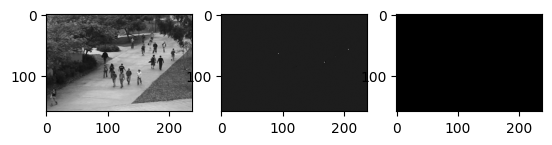

In [4]:
plt.subplot(131), plt.imshow(orig_reshaped[50], cmap="gray")
plt.subplot(132), plt.imshow(sparse_reshaped[50], cmap="gray")
plt.subplot(133), plt.imshow(lowrank_reshaped[50], cmap="gray")